In [ ]:
%matplotlib inline
# Use autoreload so that updating hmm_class.py is immediately reflected in future cell executions in the notebook.
# For details on the autoreload extension, see
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from sklearn.metrics import confusion_matrix
from hmm_class import HMM
from gaussian import Gaussian

# Verskuilde Markov Modelle (VMMe)

Tot nou toe het ons al die data waarmee ons gewerk het as onafhanklik en indenties versprei beskou - d.i. al die verskillende waarnemings is beskou as onafhanklik van mekaar - selfs in gevalle waar dit duidelik nie die geval is nie, soos met die handtekening data waar elke koördinaat afhang van vorige koördinate.

Een van die kerntake van masjienleer is om afhanklikhede tussen veranderlikes te modelleer.  VMMe is ontwerp om presies hierdie te doen.  Deesdae weet ons dat VMMe net 'n besonder eenvoudige voorbeeld is van 'n meer algemene klas modelle, naamlik probabilisties grafiese modelle.

VMMe modelleer dinamies prosesses, of prosesse wat as dinamies beskou kan word.  Prakties beteken dit dat ons 'n dinamiese proses waarneem wat ons verskaf met waarnemings by opeenvolgende tydstippe.  Handtekeninge is 'n goeie voorbeeld: Op vaste intervalle registreer die tablet die $x$ en $y$ koördinate (onder andere) van die pen.  Deur hierdie punte in orde te plot, kan ons die handtekening vertoon.

Vir die VMM, is die idee dat die stelsel in een van 'n eindige versameling van $k$ (voortbringende) toestande op elke tydstip wat 'n waarneming voortgebring word.  Dit beteken dat ons gaan werk met diskrete toestande.  Alhoewel ons dit nie hier ondersoek nie, is dit ook moontlik om met kontinue toestande te werk, 'n situasie wat gemodelleer word deur die Kalman filter.  In beide gevalle is die toestandsekwensie soos wat die tyd verloop tussen tydstippe verskuil (onbekend), aldus die *verskuil* in verskuilde Markov modelle.

Elke voortbringende toestand word geassosieer met 'n waarskynlikheidsdigtheidsfunksie (wdf).  Ons sal eenvoudigheidshalwe die Gaussiese verdeling gebruik; 'n meer algemene keuse sou Gaussiese mengselmodelle (GMMe) wees. Die model spesifiseer dan dat die die waarneming voortgebring deur 'n voortbringende toestand verkry word deur 'n waarde volgens daai toestand se wdf te trek. Dus word die data wat ons in praktyk waarneem beskou asof dit voortgebring is deur waardes volgens die wdf's van die voortbringende toestande te trek, terwyl die onderliggende toestand oor tyd verander.

Dit is gerieflik om met addisionele, nie-voortbringende, toestande ook te werk.  Vir hierdie kursus (en in u kode), is die aanvanklike en finale toestande, genommer -1 en $k$, nie-voortbringend.

Die parameters geassosieer met 'n VMM, en wat tipies van afrigdata bepaal moet word, is

* Die oorgangswaarskynlikhede $A_{ij}$, waar $A_{ij}$ die waarskynlikheid is dat die stelsel in die volgende tydstip sal oorgaan na toestand $j$, gegee dat dit huidig in toestand $i$ is. Hierdie is wat hierdie 'n (eerste-orde) *Markov* model maak, aangesien die volgende tydstip se toestand slegs bepaal word deur die vorige toestand, en nie toestande voor dit nie (as die vorige toestand bekend is). In die konteks van PGMe, is dit nie moeilik om hierdie idee te veralgemeen na hoër-orde modelle toe, maar ons sal net eerste-orde modelle hier aanpak.  Let ook op dat dit moontlik is om in dieselfde toestand te bly in opeenvolgende tydstippe, d.i. $A_{ii}$ is nie noodwendig nul nie. In beginsel is daar geen beperking op hoe die stelsel tussen toestande beweeg nie, maar die implementasie wat u in hierdie taak sal ontwikkel is beperk tot 'n links-na-regs model. Dit beteken dat die stelsel vanaf toestand $i$ slegs kan oorgaan na toestand $j$ as $j\geq i$. Laastens, let op dat die $A_{ij}$ waarkskynlikhede is, en dus genormaliseer is sodat $\sum_j A_{ij} = 1$.  'n Addisionele ry en kolom word in die kode tot $A$ bygesit om oorgange van die aanvanklike nie-voortbringende toestand en na die finale nie-voortbringende toestand respektiewelik te modelleer.
* Soos hierbo genoem, word elke voortbringende toestand geassosieer met 'n wdf, wat in ons geval 'n Gaussiese verdeling sal wees. Die wdf's moet ook beraam word tydens die afrigfase. Hierdie fase is sensitief tot vreemde situasies waar daar nie genoeg data geassosieer word met 'n spesifieke voortbringende toestand, wat na ontaarde Gaussiese verdelings en soortgelyke probleme lei.  **Die kode mag dus ongebruikte voortbringende toestande verwyder tydens die afrigproses**
* VMMe is *generatiewe* modelle; dit is dus moontlik om waardes te genereer vanaf 'n afgerigte VMM, wat getrek word uit die implisiete wdf wat die VMM voorstel. Byvoorbeeld, vir 'n handtekeningverifikasiestelsel sou 'n model dalk ontwikkel word vanaf die beskikbare handtekeninge vir 'n indiwidu.  Daarna is dit moontlik om nuwe "handtekeninge" te genereer wat soos die afrigdata lyk (uit die model se perspektief).

### Sagteware

`scikit-learn` het nie 'n VMM implementasie nie; dus sal u in hierdie taak 'n VMM biblioteek ontwikkel vanaf 'n kodeskelet wat aan u verskaf word. Om dinge hanteerbaar te hou, sal ons slegs modelle met 'n links-na-regs topologie en Gaussiese uitstralingsdigthede beskou. (U mag ook belangstel om die HMMlearn python biblioteek te ondersoek, of verder daarmee te eksperimenteer.)

Die skeletkode verskaf in `hmm_class.py` bevate verskeie funksies wat u moet voltooi - hierdie word aangedui deur die `pass` sleutelwoord.  As die klas uitgevoer word (met `python3 hmm_class.py` op die bevelreël), word verskeie dokumentasietoetse ("doctests") uitgevoer om aan te dui of u kode soos verwag funksioneer.  Hierdie dokumentasietoetse is basies ipython sessies wat kode met die verwagte ooreenstemmende afvoer wys.

*Riglyne oor implementasievolgorde*:

0. Lees versigtig die dokumentasiestringe ("docstrings") en kyk na die dokumentasietoetse in die kodeskelet om 'n verstaan van die struktuur van die klas te ontwikkel.
1. U moet 7 functions heeltemal of gedeeltelik implementeer.
2. Vier van hulle kan getoets word deur 'n VMM met 'n gespesifiseerde oorgangsmatriks en uitstralingsdigthede te gebruik m.b.v. die load funksie: sample, \_forward, \_score, and \_viterbi.
3. Die belangrikste van hierdie is \_viterbi, want dit word benodig deur \_calcstates.
4. \_updatecovs word saam met \_calcstates gebruik om \_em te implementeer.

Let op dat om hierde uit te voer nadat implementasie voltooi is 'n redelike groot bewerking is, en kan dus 'n rukkie neem.  Ons implementasie neem rofweg 15 sekondes op 'n Dell Latitude E6520.


### 'n Eenvoudige voorbeeld

Laat ons 'n eenvoudige voorbeeld beskou waarmee mens kan kyk wat gebeur, gebaseer op die kommentaar in die kode.  Hier verskaf ons 2 sekwensies (seine) van 1-dimensionele waarnemings as afrigdata - die eerste met 11 waarnemings, en die tweede met 7.

Deur die seine naderby te kyk, kan mens sien dat die waarnemings rofweg drie trosse vorm, rondom die waardes 1.0, 0.1 and 3.5. Ons spesifiseer dus 3 (voortbringende/uitstralende) toestande. Deur die model af te rig, kry mens beraamde oorgangswaarskynlikhede tussen die toestande, asook die parameters (gemiddeldes en variansies) van die toestande se Gaussiese uitstralingsdigthede.

Ons vertoon die VMM parameters van die oplossingskode hieronder - let op dat dit ooreenstem met 'n deel van die dokumentasietoets vir die VMM klas. **Verifieer dat die afvoer vir u sin maak.  Maak seker u verstaan waarvoor die laaste ry en kolom in die oorgangstabel is.**

In [ ]:
# SAMPLE CODE: EXECUTION WILL INITIALLY FAIL

# Define signals
signal1 = np.array([[ 1. ,  1.1,  0.9, 1.0, 0.0,  0.2,  0.1,  0.3,  3.4,  3.6,  3.5]])
signal2 = np.array([[0.8, 1.2, 0.4, 0.2, 0.15, 2.8, 3.6]])

# Collect training data together
toy_data = np.hstack([signal1, signal2])
toy_lengths = [11, 7]

# Create and fit HMM model to data
toy_hmm = HMM()
toy_hmm.fit(toy_data, toy_lengths, 3)

toy_means = [d.get_mean() for d in toy_hmm.dists]
toy_covs = [d.get_cov() for d in toy_hmm.dists]
print ('Transition probabilities: ')
print (toy_hmm.trans)
print ('Means: ')
print (toy_means)
print ('Covariances: ')
print (toy_covs)

Die speelmodel hierbo verteenwoordig 'n volledig werkende model.  Op hierdie stadium sal die spelmodel nie werk nie totdat u sekere metodes geïmplementeer het.  Laat ons u intuïsie bou: veronderstel u is die volgende parameters gegee:

In [ ]:
means = [1.0,0.19285714, 3.38]     
covs = [0.01666667,0.01459184, 0.0896]

***Nou, gegee die parameters hierbo, gebruik die Gaussian klas om Gaussian voorwerpe met die gegewe gemiddeldes en variansies te skep. As u dit gedoen het, gebruik die load funksie in die VMM kodeskelet om 'n VMM model met die naam toy_hmm te inisialiseer.***

In [ ]:
trans= np.array([[0.66666667, 0.33333333, 0.0,0.0],[0.0,0.71428571,0.28571429,0.0],[0.0,0.0,0.6,0.4],[1.0,0.0,0.0 , 0.0]])

### Waardes trek uit 'n VMM

Aangesien 'n VMM 'n generatiewe model is, kan mens waardes genereer uit die model om sintetiese data te skep wat die verdeling verteenwoordig deur die model volg. Hierdie proses vervleg die kies van 'n toestandoorgang en die trek van 'n waarneming volgens die ooreenstemmende teikentoestand se uitstralingsdigtheid totdat die stelsel oorgaan in die finale, nie-uitstralende toestand.

**Voltooi die implementasie van die sample funksie in die skeletkode, en gebruik dit om 'n sein uit die speelmodel te trek. Druk die seine wat u voortbring saam met hulle geassosieerde toestandsekwensies.  U resultate sal natuurlik anders wees as hieronder, as gevolg van die ewekansige oorgange en waarnemings wat voortgebring word.**

In [ ]:
samples, states = toy_hmm.sample()
print(samples)
# Expected output: The results will vary 
#Samples
#[[0.83719479]
# [0.21245065]
# [0.12488386]
# [0.18980902]
# [0.22644558]
# [0.1983044 ]
# [0.22731078]
# [3.57053262]]
#Emission states
#[0 1 1 1 1 1 1 2]

### Berekening van (log-)aanneemlikhede
 Ons stel belang om die gesamentlike log-aanneemlikheid van 'n waargenome sein te bereken vir 'n gegewe toestandsekwensie, asook om die (rand)log-aanneemlikheid van die sein te bepaal.  **Dus gaan u twee funksies in die VMM klas implementeer wat in die kode gedokumenteer is, naamlik _score en _forward.** 

Hieronder is voorbeeldafvoer van die speelmodel wat u kan gebruik om u kode teen te toets:

***Gegee signal3 en signal4, voltooi die skeletkode se _score funksie en vergelyk u afvoer met die twee seine.***

In [ ]:
signal3 = np.array([[ 0.9515792,   0.9832767,   1.04633007,  1.01464327,  0.98207072,  1.01116689,
  0.31622856,  0.20819263,  3.57707616]])
signal4 = np.array([[ 1,   0.6,   0.5 , 3.57707616]]) 
print(toy_hmm.score(signal3, [0, 0, 0, 0, 0, 1, 1, 1, 2]))
print(toy_hmm.score(signal4, [0,1,1,2]))


# Correct output for the 2 print lines above:
#-19.900843242451643
#-8.928550038779658

# Voorwaartse algoritme
***Gegee signal3 en signal4, voltooi die skeletkode se implementasie van die voorwaartse algoritme en vergelyk u afvoer met die twee seine.*** U kan ook u implementasie toets deur die log-aanneemlikhede van al die moontlike toestandsekwensies vir 'n kort sein (soos die 4-waarneming speelvoorbeeld vroeër in hierdie notaboek) te kry met die _score funksie, en te verseker dat hulle som ooreenstem met die (rand)aanneemlikheid teruggekeer deur die voorwaartse algoritme.

**Let op dat hierdie funksies log-aanneemlikhede terugkeer, maar u moet die geassosieerde aanneemlikhede bymekaartel! Om dit te doen (insluitend wanneer u die implementasie van die voorwaartse algoritme voltooi), moet mens gereeld aanneemlikhede met baie verskillende groottes sommeer.  Dit kan lei na onakkuraatheid, oorvloei, ondervloei, en algemene numeriese berekeningsprobleme.  Om baie van hierdie onplesierighede te vermy, sal u waarskynlik van numpy se logaddexp funksie gebruik wil maak.**

In [ ]:
# Forward algorithm outputs 
print(toy_hmm.forward(signal3))
print(toy_hmm.forward(signal4))
# Expected output:
#2.905341680210209
#-7.795340116574732

### Afrig

Gewoonlik sal ons verskeie afrigseine gegee word wat gegenereer is deur dieselfde entiteit, bv. verskeie voorbeelde van die handtekeninge van 'n enkele indiwidu sal beskikbaar wees.  Die volgende stap is om die aantal voortbringende toestande $k$ te kies.  Dit vereis gewoonlik eksperimentasie met 'n valideringsdatastel.  Neem vir eers aan dit is bekend.

Afrigting verloop weer met 'n VM algoritme wat bekend staan as **Viterbi herberaming**. Die basiese idee is eenvoudig:
* Beraam of raai eers die oorgangswaarskynlikhede asook die wdf's geassosieer met elke (uitstralende) toestand.
* Gebruik dan die huidige beramings van die VMM parameters om 'n waarnemingsekwensie/sein te pas tot die model.  Hierdie word gedoen met **die Viterbi algoritme wat die optimale toestandsekwensie vir die waarnemingsekwensie bepaal**. Hou boek van die waarnemings wat toegeken is aan elke toestand, en tel ook die aantal van elk van die moontlik toestandoorgange.  Doen hierdie vir al die afrigseine.  Nadat al die afrigseine so verwerk is,behoort elke toestand 'n aantal waarnemings te hê wat daaraan toegeken was.(As daar 'n leë toestand is, behoort dit verwyder te word).  Die waarnemings geassosieer met 'n toestand word gebruik om die wdf van daai toestand te beraam.  Die aantalle van die verskillende toestandoorgange wat ook bereken is, hoef net genormaliseer te word om nuwe toestandoorgangswaarskynlikhede te bepaal.
* Met a nuwe beraming van die VMM beskikbaar, word die proses herhaal tot konvergensie.

(Let op: die VM algoritme wat gebruik is om 'n GMM te pas het verantwoordelikhede gebruik om waarnemings gedeeltelik toe te ken aan al die komponente; in teenstellig, hierdie weergawe van die VM algoritme **ken elke waarneming heeltemal aan slegs een uitstralende toestand toe**.  'n Soortgelyke gedeeltelike (of "sag") toekenningstrategie bestaan ook vir die afrig van VMMe, en staan bekend as die Baum-Welch algoritme.)

# Viterbi algoritme
Gegee 'n sein, vind die Viterbi algoritme die optimale toestandoorgangsekwensie wat die waarnemings verduidelik.  Dit lê dan in wese by die hart van die VMM.  Ons het hierbo verduidelik hoe deurslaggewend die Viterbi algoritme is tydens die afrigproses.  Dit lê ook by die hart van inferensie op nuwe seine na die model afgerig is.
***Voltooi die skeletkode vir die Viterbi algoritme en vergelyk u afvoer met die twee seine hieronder.*** Een verstandigheidstoets vir die log-aanneemlikheid wat teruggekeer word deur u Viterbi kode is om te verseker dat dit dieselde log-aanneemlikheid gee as die score funksie op die toestandsekwensie wat die Viterbi kode terugkeer.

In [ ]:
signal5 = np.array([[ 0.9515792,   0.9832767,   1.04633007,  1.01464327,  1.98207072,  1.01116689,
  0.31622856,  0.20819263,  2.57707616]])
seq5, ll5 = toy_hmm.viterbi(signal5)
print(seq5)
print(ll5)

signal6 = np.array([[ 1,   0.6,   1.9773 , 2.653997]]) 
seq6, ll6 = toy_hmm.viterbi(signal6)
print(seq6)
print(ll6)
# Expected output:
#[0 0 0 0 0 0 1 1 2]
#-29.39974846423692
#[0 1 2 2]
#-20.482121728698644

Neem kennis dat die kode hierbo die mees waarskynlike toestandsekwensie onder die gegewe model terugkeer, en nie noodwendig die ware onderliggende toestandsekwensie nie.  **Dit is leersaam om deur die stappe van die laaste voorbeeld met 'n sakrekenaar of die Python interpreteerder te werk, om te verseker dat u nie algemene foute maak wat sou lei na die verkeerde toestandsekwensie [0 1 1 2].**

**Voltooi die implementasie van die _calcstates, _updatecovs, en _em funksies in die skeletkode.  Gebruik dit om die toy_hmm af te rig, en vergelyk u resultate met die aan die begin van die taak.  Let asb. op dat die seine ook nodig is wanneer u die fit() funksie gebruik.**

# Voorbereiding van die data.

In hierdie taak, sal ons VMMe toepas op die handtekeningdata wat ons in vroeër take gebruik het.  Ons gebruik weereens net die $x$- en $y$-komponente. Ons lees net 3 van die 15 handtekeninge van 'n indiwidu in met `read_signatures` hieronder, en gebruik hulle vir afrig. Let op hoe die afrighandtekeninge eers genormaliseer word voordat hulle vir die afrig van die VMM verskaf word.  Neem kennis dat ons later 'n handtekeningklassifikasiestelsel gaan toets met die ander 12 handtekeninge vir elke indiwidu.

In [ ]:
# Some utility functions:

def read_signatures(file):
    '''
    Read all the signatures in a given directory.
    
    Parameters:
    -----------
    file: string
        The name of the directory.
        
    Return:
    -------
    sign: (n,) list
        A list with all the signatures in the directory.
    
    Example
    -------
    >>>from utils import read_signatures
    >>>sign = read_signatures('./data/signatures/sign1/*.txt')       
    >>>print len(sign)
       15
    >>>print sign[0].shape
       (5, 306)
    '''
    import glob
    list_of_files = glob.glob(file) 
    sign = []
    for file_name in list_of_files:
        sign.append(np.loadtxt(file_name,  comments = '%').T)
    return sign

def sign_norm(sign):
    '''   
    Normalize a signature with respect to position, scale and rotation. 
    The aspect ratio is kept intact. Note that only the x,y coordinates are
    used.
    
    Parameters
    -----------
    sign: (2,n) ndarray
        The signature, consisting of n samples of x,y coordinates.
    
    Return
    ------
    
    rot_sign: (2,n) ndarray
        The normalized signature.
    '''
    #sign = sign
    d,n = sign.shape
    sign = sign - np.mean(sign,axis=1)[:,np.newaxis]
    #sign = (sign - mean)
    u, s, vh = np.linalg.svd(sign,full_matrices=False)
    # Try and establish the correct sign of the singular vectors.
    if u[0,0]<0. :
        vh[0,:] = -vh[0,:]
    if u[1,1]<0. :
        vh[1,:] = -vh[1,:]
    sign_norm = np.sqrt(n)*np.diag(s).dot(vh)/s[0]
    return sign_norm

In [ ]:
sign = read_signatures('../resources/data/signatures/sign2/*.txt')
n_signs = len(sign)-12
data = sign_norm(sign[0][:2, :])
length = [sign[0].shape[1]]
plt.figure("Signatures: signatory 2")
plt.plot(data[0,:],data[1,:])
for i in range(n_signs-1):
    signi = sign_norm(sign[i+1][:2, :])
    data = np.hstack((data,signi))
    length.append(sign[i+1].shape[1])
    plt.plot(signi[0,:],signi[1,:])
print (data.shape)
print (length)



**Gebruik die benadering hierbo om afrighandtekeninge vir elke indiwidu in te lees, en rig 'n VMM af vir elke indiwidu. Gebruik 5 uitstralende toestande en diagonaal kovoariansiematrikse.  Ons sal meeste van hierdie modelle later gebruik.  Gebruik die VM en Viterbi algoritme implementasies wat u hierbo voltooi het.**

In [ ]:
def get_signer_data(signer_num, num_features=2, num_test=12):
    sign = read_signatures('../resources/data/signatures/sign'+str(signer_num)+'/*.txt')
    n_signs = len(sign)-num_test
    data = sign_norm(sign[0][:num_features, :])
    length = [sign[0].shape[1]]
    for i in range(n_signs-1):
        signi = sign_norm(sign[i+1][:num_features, :])
        data = np.hstack((data,signi))
        length.append(sign[i+1].shape[1])
    return data, length

sign_models = []
for signer in range(5):
    sign_hmm = HMM()
    data, length = get_signer_data(signer+1)
    sign_hmm.fit(data, length, 5)
    sign_models.append(sign_hmm)

### Visualiseer die verskillende toestande - Viterbi op handtekeninge

Dit is leersaam om die toekenning van die waarnemings aan die toestande te visualiseer vir die handtekeninge.

**Neem lukraak 2 afrighandtekeninge van verskillende indiwidue, ken die waarnemings aan toestande toe met die Viterbi algoritme, en plot die waarnemings (met elke handtekening op 'n verskillende grafiek).  Kleur elke waarneming op grond van die toestand waaraan dit toegeken is.  Die beelde wat u skep behoort ietwat soos volg te lyk - hierdie voorbeeld was vir ondertekenaar 2 met 10 uitstralende toestande):**

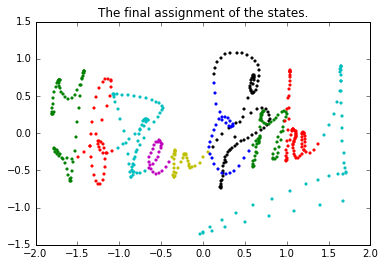

In [4]:
display(Image(filename='../resources/images/hmm1.png'))

In [ ]:
# TODO: INSERT CODE FOR ABOVE INSTRUCTION HERE


# Handtekeningklassifikasie


Neem aan ons het probabilistiese modelle vir 'n aantal ondertekenaars gebou.  As die kliënt 'n groot bank is, kan dit miljoene wees.  Vir handtekeningverifikasie, word u 'n handtekeningsein gegee, asook 'n bewering oor die identiteit van die ondertekenaar.  Die doel van die stelsel is dan om die bewering te verifieer.  Dit beteken dat die handtekeningsein gepas moet word aan die model wat ooreenstem met die beweerde ondertekenaar. As dit goed pas, word die handtekening aanvaar; andersins word dit verwerp.  Dit is nie so duidelik hoe om te besluit wat 'n goeie passing is nie, en ons sal dit dus nie hier verder ondersoek nie. Wat ons wel hier kan doen, is die goedheid van die passing tussen die model en die sein op 'n manier kwantifiseer. Die algoritme wat ons hiervoor gebruik is **die voorwaartse algoritme wat die log-randaanneemlikheid van die waargenome sein onder die model terugkeer**. Aangesien 'n (log-)aanneemlikheid teruggekeer word, en nie 'n waarskynlikheid nie, is dit nie so maklik om te besluit watter waarde vir die passing aanvaarbaar is vir verifikasie doeleindes nie, soos hierbo aangedui.  (Verder, aangesien die aanneemlikheid afhang van die sein se lengte, is dit algemeen om die (log-)aanneemlikheid te normaliseer m.b.t. die aantal waarnemings in die sein.)

Ons rig nou ons aandag op die klassifikasie van handtekeninge wanneer ons weet dat die handtekening gemaak is deur een van 'n spesifieke group indiwidue, d.w.s. handtekeningklassifikasie.  Let weereens op dat handtekeningverifikasie 'n breër probleem is - ons hanteer hierso nie die addisionele komplikasies wat hier nek uitsteek verder nie.

Vir hierdie afdeling, gebruik ons die VMM modelle wat ons vroeër vir ons ondertekenare gebou het, en gebruik hulle om die 5 toetshandtekeninge vir elke indiwidu te klassifiseer. **Neem aan elke ondertekenaar is ewe waarskynlik a priori, en klassifiseer dan elke handtekening met hierdie modelle.  Verskaf 'n verwarringsmatriks en die toetsakkuraatheid van die klassifisserder**.

In teorie, word die aanneemlikheid van 'n handtekening bereken met die voorwaartse algoritme, maar dit is ook algemeen om dit te benader met die aanneemlikheid van die mees waarskynlike toestandsekwensie, soos onttrek uit die Viterbi algoritme.  Vir hierdie taak, gebruik die laasgenoemde benadering as u versuimbenadering.  *Maar wees bewus van hierdie benadering.*

In [ ]:
# Utility function to plot confusion matrix returned by sklearn.metrics.confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', target_names = np.array(['1', '2', '3', '4', '5']), cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import math

def get_test_signals(signer_num, num_features=2, num_test = 12):
    sign = read_signatures('../resources/data/signatures/sign'+str(signer_num)+'/*.txt')
    n_signs = len(sign)-num_test
    data = sign_norm(sign[n_signs][:num_features, :])
    length = [sign[n_signs].shape[1]]
    for i in range(n_signs+1, len(sign)):
        signi = sign_norm(sign[i][:num_features, :])
        data = np.hstack((data,signi))
        length.append(sign[i].shape[1])
    return data, length

testsigs = []
groundTruth = []
predict = []

for signer in range(5):
    data, length = get_test_signals(signer+1)
    newSigs = np.hsplit(data, np.cumsum(length)[:-1])
    groundTruth += [(signer+1)] * len(newSigs)
    testsigs += newSigs

# TODO
# Write code here to calculate the predicted class for each signature.
# Put the results in the variable "predict"

In [ ]:
# After completing the code cell above, this should plot the confusion matrix.
cm = confusion_matrix(groundTruth, predict)
plot_confusion_matrix(cm)